## Image classifier for Jiu-Jitsu and Judo with less than 250 pictures
Inspired by lessons 1 and 2 of the third course by [fastai](fast.ai).

Deep learning advances in recent years mean that state of the art results in formerly complex image classification tasks, such as the ability to discern between a cat and a dog, or different pet breeds, beyond 99% accuracy is achievable with minimal training and preprocessing. 

This notebook explores making ones own dataset from Google Images, and seeing how a relatively small dataset can yield worthwhile results by standing on the shoulders of pre-trained models -- resnet in this case. 

Training an algorithm to recognize the difference between Brazilian Jiu-Jitsu and Judo seemed an interesting challenge since they look so similar; practitioners of both sports wear the traditional 'gi', usually white or blue, and photos generally exhibit two combatants grappling. 

The difference I hope to algorithms pick up upon is based on the two arts' approach. In very general terms and of course plenty of exceptions, Brazilian jiu-jitsu takes place on the ground, with each practitioner trying to physically outwit the other to achieve a position where the opponent submits. 

In Judo, points can be scored by throwing the opponent from a standing position, as well as by pinning their body to the ground. Again, this is a very general hypothesis and there will certainly be many exceptions, however, I hope the model will learn that pixels showing standing practioners attempting a throwm may reveal themselves to be Judo, whereas tighter grappling on the ground may more often than not be Jiu-Jitsu. 

In [1]:
from fastai.vision import *

## Collecting a list of URLs
-With thanks to fastai's [tutorial](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson2-download.ipynb) on image scraping.

Here's the short version: search for the images of interest, scroll down until there are a few hundred showing, then download into a file using this javascript code in the console (accessed via developer tools (<kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>J</kbd> in Windows/Linux and <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>J</kbd> in Mac)). 

```javascript
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

The image urls will appear as a file in your downloads folder. Open as a text file.

### Create directory and upload urls file into your server

The fastai library is filled with features to make our lives easier as developers, and to help everyone get up and running with deep learning. We will use some of their excellent `vision` library to convert the urls into images we can work with.

Choose an appropriate name for your labeled images. You can run these steps multiple times to grab different labels.

In [2]:
folder = 'bjj'
file = 'urls_bjj.txt'

In [3]:
folder = 'judo'
file = 'urls_judo.txt'

You will need to run this line once per each category.

In [3]:
path = Path('data/grappling_arts/')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [4]:
path.ls()

[WindowsPath('data/grappling_arts/.ipynb_checkpoints'),
 WindowsPath('data/grappling_arts/bjj'),
 WindowsPath('data/grappling_arts/cleaned.csv'),
 WindowsPath('data/grappling_arts/judo'),
 WindowsPath('data/grappling_arts/models'),
 WindowsPath('data/grappling_arts/urls_bjj.txt'),
 WindowsPath('data/grappling_arts/urls_judo.txt')]

Finally, upload your urls file. You just need to press 'Upload' in your working directory and select your file, then click 'Upload' for each of the displayed files.

![uploaded file](images/download_images/upload.png)

## Download images

Now to download the images from their respective urls.

fast.ai has a function that allows us to specify the urls filename and the destination folder and which then downloads and saves all images that can be opened. If they have some problem in being opened, they will not be saved.

Let's download our images! Notice you can choose a maximum number of images to be downloaded. We'll stick to 200 images since I hope to experiment with how far a relatively small amount of data can take us.

We run this line once for every category.

In [5]:
classes = ['bjj','judo']

In [7]:
# download_images(path/file, dest, max_pics=200)

In [8]:
# If you have problems download, try with `max_workers=0` to see exceptions:
# download_images(path/file, dest, max_pics=20, max_workers=0)

Then we can remove any images that can't be opened:

In [6]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

bjj


judo


## View data

In [7]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(max_rotate=25), size=224, num_workers=4).normalize(imagenet_stats)

Let's take a look at some of our pictures. Notice how both BJJ and Judo look like highly similar activities.

In [8]:
data.classes

['bjj', 'judo']

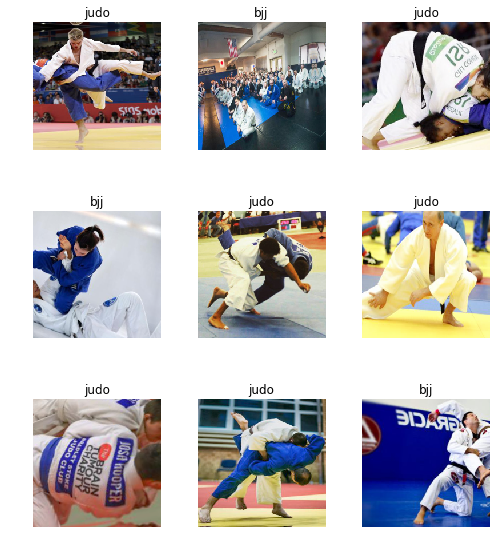

In [9]:
data.show_batch(rows=3, figsize=(7,8))

In [10]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['bjj', 'judo'], 2, 190, 47)

## Train model

In [11]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [12]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,1.123573,1.109802,0.574468
2,0.874424,0.750270,0.382979
3,0.716562,0.636145,0.319149
4,0.611191,0.543403,0.255319


In [13]:
learn.save('stage-1')

### Unfreezing

In transfer learning, the network's layers use pretrained weights for all but the last layer, which instead adapts to the dataset in question (BJJ and Judo in this case). Let's see if 'unfreezing' the layers, so that the rest of the layers also learn from this specific dataset, yields any improvement.

In [14]:
learn.unfreeze()

The fastai library also comprises handy functions for finding an optimal learning rate. Based on the 2015 [paper](https://arxiv.org/abs/1506.01186) by Leslie N. Smith, the ```lr_find``` method runs through the batch for training data, beginning with a low learning rate and then increasing it exponentially. We can then plot a graph to see the most effective parameters to choose.

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


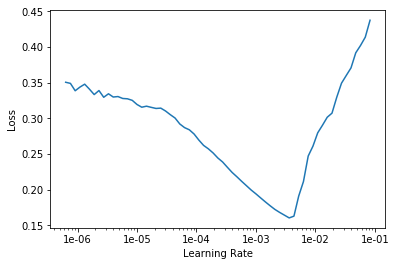

In [16]:
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(4, max_lr=slice(1e-4,1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.336470,0.251740,0.085106
2,0.358835,4.159624,0.382979
3,0.370474,2.593268,0.340426
4,0.338180,1.140388,0.170213


The accuracy decreases after unfreezing. My estimation is that since we are using less that 400 images, we don't have a sufficient sample size for the network to develop good insights and activations.

In [18]:
learn.save('stage-2')

In [19]:
learn.load('stage-2');

In [20]:
interp = ClassificationInterpretation.from_learner(learn)

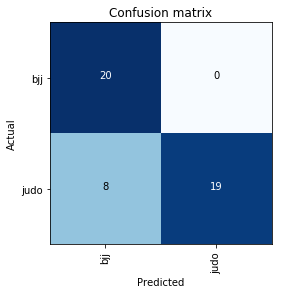

In [21]:
interp.plot_confusion_matrix()

We can instead use the `freeze_to()` function to freeze all but the last two layers.

In [22]:
learn.freeze_to(-2)
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,0.244251,0.344327,0.063830
2,0.175082,0.685953,0.148936
3,0.121048,0.429749,0.148936
4,0.124370,0.140352,0.042553


Better! Let's check the repeat offenders:

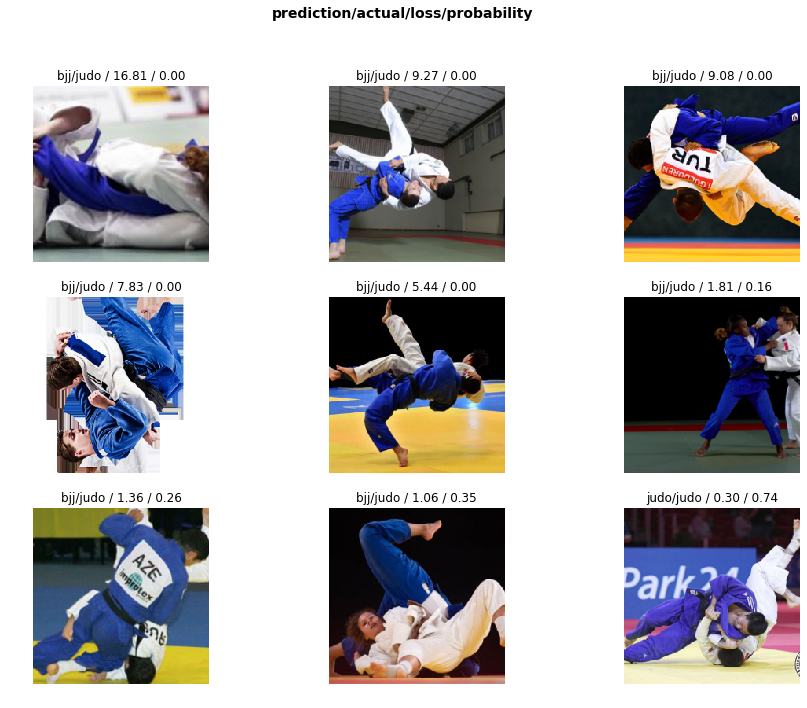

In [23]:
interp.plot_top_losses(9, figsize=(15,11))

The algorithm often mistakes a tight clinch in Judo (probably more common to BJJ) with bodies in mid-air (probably more common in Judo) as BJJ. Still, above 90% accuracy is solid for a training set of less than 250 images for a task I esimate would be very difficult for humans. 

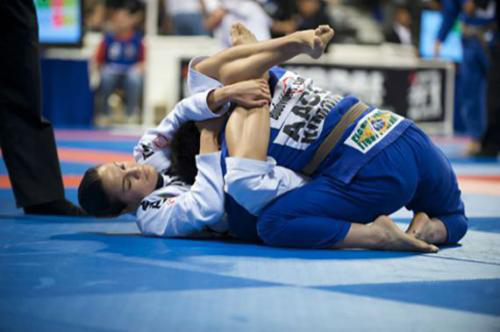

In [24]:
img = open_image(path/'bjj'/'00000055.jpg')
img

In [25]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category bjj

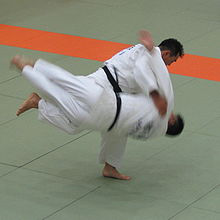

In [26]:
img = open_image(path/'judo'/'00000052.jpg')
img

In [39]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category judo